# TEST CLIMATOLOGICAL OUTLIERS FUNCTION

In [81]:
# Import libraries
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import glob

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import QAQC libraries

In [82]:
import os
import tempfile
import argparse 

# Import all qaqc script functions
try:
    from qaqc_plot import *
    from qaqc_utils import *
    from qaqc_wholestation import *
    from qaqc_logic_checks import *
    from qaqc_buoy_check import *
    from qaqc_frequent import *
    from qaqc_unusual_gaps import *
    from qaqc_unusual_large_jumps import *
    from qaqc_climatological_outlier import *
    from qaqc_unusual_streaks import *
except Exception as e:
    print("Error importing qaqc script: {}".format(e))

# Import qaqc stage calc functions
try:
    from QAQC_pipeline import *
except:
    print("Error importing QAQC_pipeline.py")
    
if not os.path.exists("./qaqc_figs"):
    os.makedirs("./qaqc_figs")

## Load file and convert to pandas df 

In [3]:
""" Aqaqc_world_recordtions from QAQC libraries can be used here.
    For the qaqc pipeline, we need the pandas df in the same format used in it
"""

network = "RAWS"
rawdir, cleandir, qaqcdir, mergedir = get_file_paths(network)
print(rawdir)
print(cleandir)
print(qaqcdir)
print(mergedir)

1_raw_wx/RAWS/
2_clean_wx/RAWS/
3_qaqc_wx/RAWS/
4_merge_wx/RAWS/


In [4]:
ls Train_Files/RAWS*

Train_Files/RAWS_KBNC1.nc  Train_Files/RAWS_TT454.nc
Train_Files/RAWS_PKLC2.nc  Train_Files/RAWS_UINU1.nc
Train_Files/RAWS_TFRU1.nc  Train_Files/RAWS_ZMBA2.nc


In [124]:
""" We can test in the same way that the pipeline, 
    take a network and subsample an station
"""

files, stations = read_network_files(network, cleandir)
stations_sample = stations.sample(1)
station = stations_sample.iloc[0]

station = "RAWS_TFRU1"
station = "RAWS_UINU1"
station = "RAWS_TCTM8"
station = "RAWS_TR782"

print(station)
print("Train_Files/{}.nc".format(station))

RAWS_TR782
Train_Files/RAWS_TR782.nc


In [125]:
%%time

""" We could load station files from the 
    s3 bucket
"""
file_name = cleandir + station + ".nc"
aws_url = "s3://wecc-historical-wx/"+file_name

try:
    print("open file locally")
    ds = xr.open_dataset("Train_Files/{}.nc".format(station)).load()
except:
    print("file not found locally, opening from s3 bucket")
    fs = s3fs.S3FileSystem()
    with fs.open(aws_url) as fileObj:
        ds = xr.open_dataset(fileObj).load()
df, MultiIndex, attrs, var_attrs = qaqc_ds_to_df(ds)        

open file locally
CPU times: user 206 ms, sys: 22.6 ms, total: 228 ms
Wall time: 249 ms


In [126]:
df.head()

,time,tas,pr,hurs,sfcWind,sfcWind_dir,tas_qc,hurs_qc,sfcWind_qc,sfcWind_dir_qc,...,tdps_derived_eraqc,elevation_eraqc,anemometer_height_m,thermometer_height_m,station,hour,day,month,year,date
0,2007-09-07 20:20:00,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,...,NaN,NaN,NaN,NaN,RAWS_TR782,20,7,9,2007,2007-09-07
1,2008-01-23 20:29:00,279.82,0.0,NaN,NaN,NaN,nan,nan,nan,nan,...,NaN,NaN,NaN,NaN,RAWS_TR782,20,23,1,2008,2008-01-23
2,2008-01-23 21:29:00,279.26,0.0,50.0,2.68,120.0,nan,nan,nan,nan,...,NaN,NaN,NaN,NaN,RAWS_TR782,21,23,1,2008,2008-01-23
3,2008-01-23 22:29:00,278.71,0.0,51.0,0.90,114.0,nan,nan,nan,nan,...,NaN,NaN,NaN,NaN,RAWS_TR782,22,23,1,2008,2008-01-23
4,2008-01-23 23:29:00,278.15,0.0,59.0,1.79,154.0,nan,nan,nan,nan,...,NaN,NaN,NaN,NaN,RAWS_TR782,23,23,1,2008,2008-01-23


## Log file and error handling

In [127]:
# Set up error handling.
errors, end_api, timestamp = setup_error_handling()

In [128]:
global log_file
log_file = open("logtest.log","w")
verbose=True

## Whole station and logic checks

### Part 1a: Whole station checks - if failure, entire station does not proceed through QA/QC

In [129]:
t0 = time.time()
printf("QA/QC whole station tests", log_file=log_file, verbose=verbose, flush=True)

07-01-2024 18:59:14 : 	 QA/QC whole station tests


In [130]:
#---------------------------------------------------------
## Missing values -- does not proceed through qaqc if failure
stn_to_qaqc = df.copy()  # Need to define before qaqc_pipeline, in case 
new_df = qaqc_missing_vals(stn_to_qaqc, verbose=verbose)
if new_df is None:
    raise
else:
    stn_to_qaqc = new_df
    printf('pass qaqc_missing_vals', log_file=log_file, verbose=verbose, flush=True)

07-01-2024 18:59:15 : 	 Running: qaqc_missing_vals
07-01-2024 18:59:15 : 	 Updating missing values for: tas
07-01-2024 18:59:15 : 	 Updating missing values for: pr
07-01-2024 18:59:15 : 	 Updating missing values for: hurs
07-01-2024 18:59:15 : 	 Updating missing values for: sfcWind
07-01-2024 18:59:15 : 	 Updating missing values for: sfcWind_dir
07-01-2024 18:59:15 : 	 Updating missing values for: tdps_derived
07-01-2024 18:59:15 : 	 pass qaqc_missing_vals


In [131]:
#---------------------------------------------------------
## Lat-lon -- does not proceed through qaqc if failure
new_df = qaqc_missing_latlon(stn_to_qaqc, verbose=verbose)
if new_df is None:
    raise
else:
    stn_to_qaqc = new_df
    printf('pass qaqc_missing_latlon', log_file=log_file, verbose=verbose, flush=True)

07-01-2024 18:59:15 : 	 Running: qaqc_missing_latlon
07-01-2024 18:59:15 : 	 pass qaqc_missing_latlon


In [132]:
#---------------------------------------------------------
## Within WECC -- does not proceed through qaqc if failure
new_df = qaqc_within_wecc(stn_to_qaqc, verbose=verbose)
if new_df is None:
    raise
else:
    stn_to_qaqc = new_df
    printf('pass qaqc_within_wecc', log_file=log_file, verbose=verbose, flush=True)

07-01-2024 18:59:15 : 	 Running: qaqc_within_wecc
07-01-2024 18:59:16 : 	 pass qaqc_within_wecc


In [133]:
#---------------------------------------------------------
## Elevation -- if DEM in-filling fails, does not proceed through qaqc
new_df = qaqc_elev_infill(stn_to_qaqc, verbose=verbose) # nan infilling must be before range check
if new_df is None:
    raise
else:
    stn_to_qaqc = new_df
    printf('pass qaqc_elev_infill', log_file=log_file, verbose=verbose, flush=True)

07-01-2024 18:59:16 : 	 Running: qaqc_elev_infill
07-01-2024 18:59:16 : 	 pass qaqc_elev_infill


In [134]:
#---------------------------------------------------------
## Elevation -- range within WECC
new_df = qaqc_elev_range(stn_to_qaqc, verbose=verbose)
if new_df is None:
    raise
else:
    stn_to_qaqc = new_df
    printf('pass qaqc_elev_range', log_file=log_file, verbose=verbose, flush=True)

07-01-2024 18:59:16 : 	 Running: qaqc_elev_range
07-01-2024 18:59:16 : 	 Elevation values post-infilling/correcting: [1116.7872]
07-01-2024 18:59:16 : 	 pass qaqc_elev_range


### Part 1b: Whole station checks - if failure, entire station does proceed through QA/QC

In [135]:
## Pressure units fix (temporary)
new_df = qaqc_pressure_units_fix(stn_to_qaqc, verbose=verbose)
if new_df is None:
    raise
else:
    stn_to_qaqc = new_df
    printf('pass qaqc_pressure_units_fix', log_file=log_file, verbose=verbose, flush=True)    

07-01-2024 18:59:16 : 	 Running: qaqc_pressure_units_fix
07-01-2024 18:59:16 : 	 pass qaqc_pressure_units_fix


In [136]:
#---------------------------------------------------------
## World record checks: air temperature, dewpoint, wind, pressure
new_df = qaqc_world_record(stn_to_qaqc, verbose=verbose)
if new_df is None:
    raise
else:
    stn_to_qaqc = new_df
    printf('pass qaqc_world_record', log_file=log_file, verbose=verbose, flush=True)

printf("Done whole station tests, Ellapsed time: {:.2f} s.\n".format(time.time()-t0), log_file=log_file, verbose=verbose, flush=True)

07-01-2024 18:59:16 : 	 Running: qaqc_world_record
07-01-2024 18:59:16 : 	 pass qaqc_world_record
07-01-2024 18:59:16 : 	 Done whole station tests, Ellapsed time: 2.50 s.



In [137]:
printf("Done whole station tests, Ellapsed time: {:.2f} s.\n".format(time.time()-t0), log_file=log_file, verbose=verbose, flush=True)

07-01-2024 18:59:16 : 	 Done whole station tests, Ellapsed time: 2.52 s.



### Part 2: Variable logic checks

In [138]:
t0 = time.time()
printf("QA/QC logic checks", log_file=log_file, verbose=verbose, flush=True)

07-01-2024 18:59:18 : 	 QA/QC logic checks


In [139]:
#---------------------------------------------------------
## dew point temp cannot exceed air temperature
new_df = qaqc_crossvar_logic_tdps_to_tas_supersat(stn_to_qaqc, verbose=verbose)
if new_df is None:
    raise
else:
    stn_to_qaqc = new_df
    printf('pass qaqc_crossvar_logic_tdps_to_tas_supersat', log_file=log_file, verbose=verbose, flush=True)

07-01-2024 18:59:18 : 	 Running: qaqc_crossvar_logic_tdps_to_tas_supersat
07-01-2024 18:59:18 : 	 pass qaqc_crossvar_logic_tdps_to_tas_supersat


In [140]:
#---------------------------------------------------------
## dew point temp cannot exceed air temperature (wet bulb drying)  
new_df = qaqc_crossvar_logic_tdps_to_tas_wetbulb(stn_to_qaqc, verbose=verbose)
if new_df is None:
    raise
else:
    stn_to_qaqc = new_df
    printf('pass qaqc_crossvar_logic_tdps_to_tas_wetbulb', log_file=log_file, verbose=verbose, flush=True)

07-01-2024 18:59:18 : 	 Running: qaqc_crossvar_logic_tdps_to_tas_wetbulb
07-01-2024 18:59:19 : 	 Flagging extended streak in dewpoint depression
07-01-2024 18:59:19 : 	 pass qaqc_crossvar_logic_tdps_to_tas_wetbulb


In [141]:
#---------------------------------------------------------
## precipitation is not negative
new_df = qaqc_precip_logic_nonegvals(stn_to_qaqc, verbose=verbose)
if new_df is None:
    raise
else:
    stn_to_qaqc = new_df
    printf('pass qaqc_precip_logic_nonegvals', log_file=log_file, verbose=verbose, flush=True)

07-01-2024 18:59:19 : 	 Running: qaqc_precip_logic_nonegvals
07-01-2024 18:59:19 : 	 Running qaqc_precip_logic_nonegvals on: ['pr']
07-01-2024 18:59:19 : 	 pass qaqc_precip_logic_nonegvals


In [142]:
#---------------------------------------------------------
## precipitation duration logic
new_df = qaqc_precip_logic_accum_amounts(stn_to_qaqc, verbose=verbose)
if new_df is None:
    raise
else:
    stn_to_qaqc = new_df
    printf('pass qaqc_precip_logic_accum_amounts', log_file=log_file, verbose=verbose, flush=True)      

07-01-2024 18:59:19 : 	 Running: qaqc_precip_logic_accum_amounts
07-01-2024 18:59:19 : 	 Station does not report multiple precipitation variables - bypassing precip logic accum check
07-01-2024 18:59:19 : 	 pass qaqc_precip_logic_accum_amounts


In [143]:
#---------------------------------------------------------
## wind direction should be 0 when wind speed is also 0
new_df = qaqc_crossvar_logic_calm_wind_dir(stn_to_qaqc, verbose=verbose)
if new_df is None:
    raise
else:
    stn_to_qaqc = new_df
    printf('pass qaqc_crossvar_logic_calm_wind_dir', log_file=log_file, verbose=verbose, flush=True)

07-01-2024 18:59:20 : 	 Running: qaqc_crossvar_logic_calm_wind_dir
07-01-2024 18:59:20 : 	 pass qaqc_crossvar_logic_calm_wind_dir


In [144]:
printf("Done logic checks, Ellapsed time: {:.2f} s.\n".format(time.time()-t0), log_file=log_file, verbose=verbose, flush=True)

07-01-2024 18:59:22 : 	 Done logic checks, Ellapsed time: 3.79 s.



## Test clim outliers

In [145]:
# climatological outliers
t0 = time.time()
printf("QA/QC climatological outliers", log_file=log_file, verbose=verbose, flush=True)

new_df = qaqc_climatological_outlier(stn_to_qaqc, verbose=verbose)
if new_df is None:
    errors = print_qaqc_failed(errors, station, end_api,
                            message="Flagging problem with climatological outlier check",
                            test="qaqc_climatological_outlier",
                            verbose=verbose)
else:
    stn_to_qaqc = new_df
    printf('pass qaqc_climatological_outlier', log_file=log_file, verbose=verbose, flush=True)

printf("Done QA/QC climatological outliers, Ellapsed time: {:.2f} s.\n".format(time.time()-t0), log_file=log_file, verbose=verbose, flush=True)

07-01-2024 18:59:22 : 	 QA/QC climatological outliers
07-01-2024 18:59:22 : 	 Running qaqc_climatological_outlier on ['tas', 'tdps_derived']
07-01-2024 18:59:22 : 	 Checking for climatological outliers in: tas
07-01-2024 18:59:22 : 	 Flagging outliers in tas
07-01-2024 18:59:22 : 	 Outliers flagged in tas
07-01-2024 18:59:22 : 	 Checking for climatological outliers in: tdps_derived
07-01-2024 18:59:22 : 	 Flagging outliers in tdps_derived
07-01-2024 18:59:22 : 	 Outliers flagged in tdps_derived
07-01-2024 18:59:32 : 	 pass qaqc_climatological_outlier
07-01-2024 18:59:32 : 	 Done QA/QC climatological outliers, Ellapsed time: 10.18 s.



In [39]:
var = "tas"

In [40]:
df_test = grab_valid_obs(stn_to_qaqc, var, kind='drop')

In [41]:
clim = df_test.groupby(["month","hour"])[var].transform(lambda row:stats.mstats.winsorize(row, limits=[0.05,0.05]))
clim = pd.DataFrame(data={var:clim, "hour":df_test.hour, "month":df_test.month}, index=df_test.index)
# clim

In [42]:
clim = clim.groupby(["month","hour"])[var].transform(lambda row: np.nanmean(row))
clim = pd.DataFrame(data={var:clim, "hour":df_test.hour, "month":df_test.month}, index=df_test.index)
# clim

In [43]:
anom = df_test[var]-clim[var]
anom = pd.DataFrame(data={var:anom, "hour":df_test.hour, "month":df_test.month}, index=df_test.index)
# anom

In [44]:
iqr = anom.groupby(["month","hour"])[var].transform(lambda row: max(np.nanpercentile(row, 75)-np.nanpercentile(row, 25), 1.5))
iqr = pd.DataFrame(data={var:iqr, "hour":df_test.hour, "month":df_test.month}, index=df_test.index)
# iqr

In [45]:
std = anom[var]/iqr[var]
std = pd.DataFrame(data={var:std, "hour":df_test.hour, "month":df_test.month}, index=df_test.index)

In [63]:
# Low-pass standardised data
cut_freq = 1/(3600*24*365/30) # In Hz (cut_period : 1 month)
data_freq = 1/(df_test['time'].diff().mode().values[0].astype("float")/1e9) # In Hz
sos = signal.butter(1, cut_freq, 'lp', output='sos', fs=data_freq)
filtered = signal.sosfilt(sos, std[var].interpolate(method="linear"))
# data = std[var].interpolate(method="linear")-filtered
data = filtered
data = pd.DataFrame(data={var:data, "hour":df_test.hour, "month":df_test.month, "time":df_test.time}, index=df_test.index)
# data

In [47]:
fig,ax = plt.subplots(figsize=(10,3))
data.plot(x="time", y="tas", ax=ax)

<AxesSubplot:xlabel='time'>

In [48]:
series = data[(data.month==10)&(data.hour==5)]
freq, bins, p, left, right = fit_normal(series['tas'], bin_size=0.1, plot=True)
series[series['tas']<-1.6]

/Users/hector/ERA_work/historical-obs-platform/test_platform/scripts/3_qaqc_data/qaqc_climatological_outlier.py:282: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


,tas,hour,month,time
7016,-1.828556,5,10,2002-10-31 05:00:00
60992,-1.796170,5,10,2009-10-13 05:15:00
148085,-1.616378,5,10,2019-10-29 05:15:00
148109,-2.046084,5,10,2019-10-30 05:15:00
148133,-1.982420,5,10,2019-10-31 05:15:00
156766,-2.021854,5,10,2020-10-26 05:15:00
156790,-1.842759,5,10,2020-10-27 05:15:00


In [49]:
series = data[(data.month==10)&(data.hour==6)]
freq, bins, p, left, right = fit_normal(series['tas'], bin_size=0.1, plot=True)
series[series['tas']<-1.6]

/Users/hector/ERA_work/historical-obs-platform/test_platform/scripts/3_qaqc_data/qaqc_climatological_outlier.py:282: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


,tas,hour,month,time
7017,-1.856320,6,10,2002-10-31 06:00:00
60993,-1.797042,6,10,2009-10-13 06:15:00
148086,-1.640821,6,10,2019-10-29 06:15:00
148110,-2.062145,6,10,2019-10-30 06:15:00
148134,-1.969030,6,10,2019-10-31 06:15:00
156743,-1.610760,6,10,2020-10-25 06:15:00
156767,-2.032817,6,10,2020-10-26 06:15:00
156791,-1.835499,6,10,2020-10-27 06:15:00


In [50]:
fig,ax = plt.subplots(figsize=(10,3))
df.plot(x="time", y="tas", ax=ax, marker=".", color="C0")
ax.set_xlim(np.datetime64("2019-10-27"),np.datetime64("2019-11-03"))
# ax.axvline(np.datetime64("2019-10-30 05:31:00"), lw=0.85, ls=":", c="k")
for h in np.concatenate([np.arange(10), [11,18,22,23]]):
    ax.axvline(np.datetime64("2019-10-30 {}:00:00".format(str(h).zfill(2))), lw=0.85, ls=":", c="k")
ax.set_ylim(255,290)

axt = ax.twiny()
df.plot(x="time", y="tas", ax=axt, marker=".", color="C1")
axt.set_xlim(np.datetime64("2018-10-27"),np.datetime64("2018-11-03"))
axt.set_ylim(250,310)

fig,ax = plt.subplots(figsize=(10,3))
df.plot(x="time", y="tas", ax=ax, marker=".", color="C0")
ax.set_xlim(np.datetime64("2017-10-27"),np.datetime64("2017-11-03"))
ax.set_ylim(255,290)

axt = ax.twiny()
df.plot(x="time", y="tas", ax=axt, marker=".", color="C1")
axt.set_xlim(np.datetime64("2020-10-27"),np.datetime64("2020-11-03"))
axt.set_ylim(250,310)

(250.0, 310.0)

In [51]:
fig,ax = plt.subplots(figsize=(10,3))

ax.plot(df.time, df.groupby(["month","hour"]).tas.transform(lambda row: np.nanmedian(row)), lw=2, c="k")
y1 = stn_to_qaqc.groupby(["month","hour"]).tas.transform(lambda row: np.percentile(row,  1)).interpolate(method="linear")
y2 = stn_to_qaqc.groupby(["month","hour"]).tas.transform(lambda row: np.percentile(row, 99)).interpolate(method="linear")
ax.fill_between(df.time, y1, y2, color="k", alpha=0.2)

df.plot(x="time", y="tas", ax=ax, marker=".", color="C0")
ax.set_xlim(np.datetime64("2019-10-27"),np.datetime64("2019-11-03"))
# ax.axvline(np.datetime64("2003-11-29 02:45:00"), ls=":", c="C0")
ax.set_ylim(255,305)

(255.0, 305.0)

In [52]:
fig,ax = plt.subplots(figsize=(10,3))
df.plot(x="time", y="tas", ax=ax, marker=".", color="C0")
ax.set_xlim(np.datetime64("2019-10-27"),np.datetime64("2019-11-03"))
# ax.axvline(np.datetime64("2019-10-30 05:31:00"), lw=0.85, ls=":", c="k")
for h in np.concatenate([np.arange(10), [11,18,22,23]]):
    ax.axvline(np.datetime64("2019-10-30 {}:00:00".format(str(h).zfill(2))), lw=0.85, ls=":", c="k")
ax.set_ylim(260,275)

(260.0, 275.0)

In [53]:
for hour in range(0,24,1):
    series = data[(data.month==10)&(data.hour==hour)]
    print(hour)
    freq, bins, p, left, right = fit_normal(series['tas'], bin_size=0.10, plot=True)
    display(series[series['tas']<-1.6])

0


/Users/hector/ERA_work/historical-obs-platform/test_platform/scripts/3_qaqc_data/qaqc_climatological_outlier.py:282: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


,tas,hour,month,time
7011,-1.693958,0,10,2002-10-31 00:00:00
60969,-1.732629,0,10,2009-10-12 00:15:00
60987,-1.800193,0,10,2009-10-13 00:15:00
148104,-1.959483,0,10,2019-10-30 00:15:00
148128,-2.020001,0,10,2019-10-31 00:15:00
156761,-1.945632,0,10,2020-10-26 00:15:00
156785,-1.874447,0,10,2020-10-27 00:15:00


1


/Users/hector/ERA_work/historical-obs-platform/test_platform/scripts/3_qaqc_data/qaqc_climatological_outlier.py:282: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


,tas,hour,month,time
7012,-1.715945,1,10,2002-10-31 01:00:00
60970,-1.741599,1,10,2009-10-12 01:15:00
60988,-1.796820,1,10,2009-10-13 01:15:00
148105,-1.976467,1,10,2019-10-30 01:15:00
148129,-2.014083,1,10,2019-10-31 01:15:00
156762,-1.959559,1,10,2020-10-26 01:15:00
156786,-1.866215,1,10,2020-10-27 01:15:00


2


/Users/hector/ERA_work/historical-obs-platform/test_platform/scripts/3_qaqc_data/qaqc_climatological_outlier.py:282: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


,tas,hour,month,time
7013,-1.742701,2,10,2002-10-31 02:00:00
60971,-1.755344,2,10,2009-10-12 02:15:00
60989,-1.794640,2,10,2009-10-13 02:15:00
148106,-1.994639,2,10,2019-10-30 02:15:00
148130,-2.010165,2,10,2019-10-31 02:15:00
156763,-1.975914,2,10,2020-10-26 02:15:00
156787,-1.861088,2,10,2020-10-27 02:15:00


3


/Users/hector/ERA_work/historical-obs-platform/test_platform/scripts/3_qaqc_data/qaqc_climatological_outlier.py:282: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


,tas,hour,month,time
7014,-1.772339,3,10,2002-10-31 03:00:00
60972,-1.774068,3,10,2009-10-12 03:15:00
60990,-1.795056,3,10,2009-10-13 03:15:00
148107,-2.012825,3,10,2019-10-30 03:15:00
148131,-2.004459,3,10,2019-10-31 03:15:00
156764,-1.992222,3,10,2020-10-26 03:15:00
156788,-1.856276,3,10,2020-10-27 03:15:00


4


/Users/hector/ERA_work/historical-obs-platform/test_platform/scripts/3_qaqc_data/qaqc_climatological_outlier.py:282: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


,tas,hour,month,time
7015,-1.801163,4,10,2002-10-31 04:00:00
60991,-1.796031,4,10,2009-10-13 04:15:00
148108,-2.030427,4,10,2019-10-30 04:15:00
148132,-1.994888,4,10,2019-10-31 04:15:00
156765,-2.007994,4,10,2020-10-26 04:15:00
156789,-1.849858,4,10,2020-10-27 04:15:00


5


/Users/hector/ERA_work/historical-obs-platform/test_platform/scripts/3_qaqc_data/qaqc_climatological_outlier.py:282: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


,tas,hour,month,time
7016,-1.828556,5,10,2002-10-31 05:00:00
60992,-1.796170,5,10,2009-10-13 05:15:00
148085,-1.616378,5,10,2019-10-29 05:15:00
148109,-2.046084,5,10,2019-10-30 05:15:00
148133,-1.982420,5,10,2019-10-31 05:15:00
156766,-2.021854,5,10,2020-10-26 05:15:00
156790,-1.842759,5,10,2020-10-27 05:15:00


6


/Users/hector/ERA_work/historical-obs-platform/test_platform/scripts/3_qaqc_data/qaqc_climatological_outlier.py:282: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


,tas,hour,month,time
7017,-1.856320,6,10,2002-10-31 06:00:00
60993,-1.797042,6,10,2009-10-13 06:15:00
148086,-1.640821,6,10,2019-10-29 06:15:00
148110,-2.062145,6,10,2019-10-30 06:15:00
148134,-1.969030,6,10,2019-10-31 06:15:00
156743,-1.610760,6,10,2020-10-25 06:15:00
156767,-2.032817,6,10,2020-10-26 06:15:00
156791,-1.835499,6,10,2020-10-27 06:15:00


7


/Users/hector/ERA_work/historical-obs-platform/test_platform/scripts/3_qaqc_data/qaqc_climatological_outlier.py:282: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


,tas,hour,month,time
7018,-1.885246,7,10,2002-10-31 07:00:00
60994,-1.795326,7,10,2009-10-13 07:15:00
148087,-1.666973,7,10,2019-10-29 07:15:00
148111,-2.077693,7,10,2019-10-30 07:15:00
148135,-1.953846,7,10,2019-10-31 07:15:00
156744,-1.635096,7,10,2020-10-25 07:15:00
156768,-2.042442,7,10,2020-10-26 07:15:00
156792,-1.828058,7,10,2020-10-27 07:15:00


8


/Users/hector/ERA_work/historical-obs-platform/test_platform/scripts/3_qaqc_data/qaqc_climatological_outlier.py:282: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


,tas,hour,month,time
7019,-1.916455,8,10,2002-10-31 08:00:00
60995,-1.785610,8,10,2009-10-13 08:15:00
148088,-1.695177,8,10,2019-10-29 08:15:00
148112,-2.093747,8,10,2019-10-30 08:15:00
148136,-1.936677,8,10,2019-10-31 08:15:00
156745,-1.662278,8,10,2020-10-25 08:15:00
156769,-2.051474,8,10,2020-10-26 08:15:00
156793,-1.820382,8,10,2020-10-27 08:15:00


9


/Users/hector/ERA_work/historical-obs-platform/test_platform/scripts/3_qaqc_data/qaqc_climatological_outlier.py:282: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


,tas,hour,month,time
7020,-1.945412,9,10,2002-10-31 09:00:00
60996,-1.772867,9,10,2009-10-13 09:15:00
148089,-1.722824,9,10,2019-10-29 09:15:00
148113,-2.108690,9,10,2019-10-30 09:15:00
148137,-1.917446,9,10,2019-10-31 09:15:00
156746,-1.689753,9,10,2020-10-25 09:15:00
156770,-2.057904,9,10,2020-10-26 09:15:00
156794,-1.810444,9,10,2020-10-27 09:15:00


10


/Users/hector/ERA_work/historical-obs-platform/test_platform/scripts/3_qaqc_data/qaqc_climatological_outlier.py:282: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


,tas,hour,month,time
7021,-1.973115,10,10,2002-10-31 10:00:00
60955,-1.605914,10,10,2009-10-11 10:15:00
60973,-1.792612,10,10,2009-10-12 10:15:00
60997,-1.765044,10,10,2009-10-13 10:15:00
148090,-1.749240,10,10,2019-10-29 10:15:00
148114,-2.121790,10,10,2019-10-30 10:15:00
148138,-1.897069,10,10,2019-10-31 10:15:00
156747,-1.717773,10,10,2020-10-25 10:15:00
156771,-2.062655,10,10,2020-10-26 10:15:00
156795,-1.798272,10,10,2020-10-27 10:15:00


11


/Users/hector/ERA_work/historical-obs-platform/test_platform/scripts/3_qaqc_data/qaqc_climatological_outlier.py:282: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


,tas,hour,month,time
7022,-2.002845,11,10,2002-10-31 11:00:00
60956,-1.627837,11,10,2009-10-11 11:15:00
60974,-1.807927,11,10,2009-10-12 11:15:00
60998,-1.758354,11,10,2009-10-13 11:15:00
148091,-1.775908,11,10,2019-10-29 11:15:00
148115,-2.137030,11,10,2019-10-30 11:15:00
148139,-1.877963,11,10,2019-10-31 11:15:00
156748,-1.747718,11,10,2020-10-25 11:15:00
156772,-2.067003,11,10,2020-10-26 11:15:00
156796,-1.783927,11,10,2020-10-27 11:15:00


12


/Users/hector/ERA_work/historical-obs-platform/test_platform/scripts/3_qaqc_data/qaqc_climatological_outlier.py:282: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


,tas,hour,month,time
7023,-2.028622,12,10,2002-10-31 12:00:00
60957,-1.645715,12,10,2009-10-11 12:15:00
60975,-1.821112,12,10,2009-10-12 12:15:00
60999,-1.745093,12,10,2009-10-13 12:15:00
148092,-1.799791,12,10,2019-10-29 12:15:00
148116,-2.149920,12,10,2019-10-30 12:15:00
148140,-1.859577,12,10,2019-10-31 12:15:00
156749,-1.776370,12,10,2020-10-25 12:15:00
156773,-2.066379,12,10,2020-10-26 12:15:00
156797,-1.766721,12,10,2020-10-27 12:15:00


13


/Users/hector/ERA_work/historical-obs-platform/test_platform/scripts/3_qaqc_data/qaqc_climatological_outlier.py:282: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


,tas,hour,month,time
7024,-2.050379,13,10,2002-10-31 13:00:00
60958,-1.661706,13,10,2009-10-11 13:15:00
60976,-1.832544,13,10,2009-10-12 13:15:00
61000,-1.723732,13,10,2009-10-13 13:15:00
148093,-1.822321,13,10,2019-10-29 13:15:00
148117,-2.159260,13,10,2019-10-30 13:15:00
148141,-1.842339,13,10,2019-10-31 13:15:00
156750,-1.803495,13,10,2020-10-25 13:15:00
156774,-2.063577,13,10,2020-10-26 13:15:00
156798,-1.748182,13,10,2020-10-27 13:15:00


14


/Users/hector/ERA_work/historical-obs-platform/test_platform/scripts/3_qaqc_data/qaqc_climatological_outlier.py:282: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


,tas,hour,month,time
7025,-2.070134,14,10,2002-10-31 14:00:00
60959,-1.676644,14,10,2009-10-11 14:15:00
60977,-1.843019,14,10,2009-10-12 14:15:00
61001,-1.706211,14,10,2009-10-13 14:15:00
148094,-1.846932,14,10,2019-10-29 14:15:00
148118,-2.169326,14,10,2019-10-30 14:15:00
148142,-1.826392,14,10,2019-10-31 14:15:00
156751,-1.829327,14,10,2020-10-25 14:15:00
156775,-2.062575,14,10,2020-10-26 14:15:00
156799,-1.730144,14,10,2020-10-27 14:15:00


/Users/hector/ERA_work/historical-obs-platform/test_platform/scripts/3_qaqc_data/qaqc_climatological_outlier.py:282: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


15


,tas,hour,month,time
7026,-2.082122,15,10,2002-10-31 15:00:00
60960,-1.687528,15,10,2009-10-11 15:15:00
60978,-1.847426,15,10,2009-10-12 15:15:00
61002,-1.696191,15,10,2009-10-13 15:15:00
148095,-1.868983,15,10,2019-10-29 15:15:00
148119,-2.175272,15,10,2019-10-30 15:15:00
148143,-1.807761,15,10,2019-10-31 15:15:00
156752,-1.851674,15,10,2020-10-25 15:15:00
156776,-2.056087,15,10,2020-10-26 15:15:00
156800,-1.711188,15,10,2020-10-27 15:15:00


/Users/hector/ERA_work/historical-obs-platform/test_platform/scripts/3_qaqc_data/qaqc_climatological_outlier.py:282: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


16


,tas,hour,month,time
7027,-2.083079,16,10,2002-10-31 16:00:00
60961,-1.695201,16,10,2009-10-11 16:15:00
60979,-1.843747,16,10,2009-10-12 16:15:00
61003,-1.686742,16,10,2009-10-13 16:15:00
148096,-1.881272,16,10,2019-10-29 16:15:00
148120,-2.166515,16,10,2019-10-30 16:15:00
148144,-1.784627,16,10,2019-10-31 16:15:00
156753,-1.867578,16,10,2020-10-25 16:15:00
156777,-2.038775,16,10,2020-10-26 16:15:00
156801,-1.686256,16,10,2020-10-27 16:15:00


/Users/hector/ERA_work/historical-obs-platform/test_platform/scripts/3_qaqc_data/qaqc_climatological_outlier.py:282: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


17


,tas,hour,month,time
7028,-2.079758,17,10,2002-10-31 17:00:00
60962,-1.701984,17,10,2009-10-11 17:15:00
60980,-1.839982,17,10,2009-10-12 17:15:00
61004,-1.676695,17,10,2009-10-13 17:15:00
148097,-1.889509,17,10,2019-10-29 17:15:00
148121,-2.146288,17,10,2019-10-30 17:15:00
148145,-1.759695,17,10,2019-10-31 17:15:00
156754,-1.879798,17,10,2020-10-25 17:15:00
156778,-2.011007,17,10,2020-10-26 17:15:00
156802,-1.654378,17,10,2020-10-27 17:15:00


18


/Users/hector/ERA_work/historical-obs-platform/test_platform/scripts/3_qaqc_data/qaqc_climatological_outlier.py:282: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


,tas,hour,month,time
7005,-1.607179,18,10,2002-10-30 18:00:00
7029,-2.076746,18,10,2002-10-31 18:00:00
60963,-1.705372,18,10,2009-10-11 18:15:00
60981,-1.835255,18,10,2009-10-12 18:15:00
61005,-1.658303,18,10,2009-10-13 18:15:00
148098,-1.897491,18,10,2019-10-29 18:15:00
148122,-2.125148,18,10,2019-10-30 18:15:00
148146,-1.735866,18,10,2019-10-31 18:15:00
156755,-1.889730,18,10,2020-10-25 18:15:00
156779,-1.977841,18,10,2020-10-26 18:15:00


/Users/hector/ERA_work/historical-obs-platform/test_platform/scripts/3_qaqc_data/qaqc_climatological_outlier.py:282: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


19


,tas,hour,month,time
7006,-1.621899,19,10,2002-10-30 19:00:00
7030,-2.071042,19,10,2002-10-31 19:00:00
60964,-1.708296,19,10,2009-10-11 19:15:00
60982,-1.828295,19,10,2009-10-12 19:15:00
61006,-1.628084,19,10,2009-10-13 19:15:00
148099,-1.906093,19,10,2019-10-29 19:15:00
148123,-2.104651,19,10,2019-10-30 19:15:00
148147,-1.715698,19,10,2019-10-31 19:15:00
156756,-1.899057,19,10,2020-10-25 19:15:00
156780,-1.950311,19,10,2020-10-26 19:15:00


/Users/hector/ERA_work/historical-obs-platform/test_platform/scripts/3_qaqc_data/qaqc_climatological_outlier.py:282: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


20


,tas,hour,month,time
7007,-1.634592,20,10,2002-10-30 20:00:00
7031,-2.062933,20,10,2002-10-31 20:00:00
60965,-1.712646,20,10,2009-10-11 20:15:00
60983,-1.822230,20,10,2009-10-12 20:15:00
61007,-1.600429,20,10,2009-10-13 20:15:00
148100,-1.916280,20,10,2019-10-29 20:15:00
148124,-2.083999,20,10,2019-10-30 20:15:00
148148,-1.698004,20,10,2019-10-31 20:15:00
156757,-1.908212,20,10,2020-10-25 20:15:00
156781,-1.931762,20,10,2020-10-26 20:15:00


/Users/hector/ERA_work/historical-obs-platform/test_platform/scripts/3_qaqc_data/qaqc_climatological_outlier.py:282: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


21


,tas,hour,month,time
7008,-1.645495,21,10,2002-10-30 21:00:00
7032,-2.057100,21,10,2002-10-31 21:00:00
60966,-1.716049,21,10,2009-10-11 21:15:00
60984,-1.815725,21,10,2009-10-12 21:15:00
148101,-1.925850,21,10,2019-10-29 21:15:00
148125,-2.063751,21,10,2019-10-30 21:15:00
148149,-1.680134,21,10,2019-10-31 21:15:00
156758,-1.916771,21,10,2020-10-25 21:15:00
156782,-1.915921,21,10,2020-10-26 21:15:00


22


/Users/hector/ERA_work/historical-obs-platform/test_platform/scripts/3_qaqc_data/qaqc_climatological_outlier.py:282: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


,tas,hour,month,time
7009,-1.656466,22,10,2002-10-30 22:00:00
7033,-2.052513,22,10,2002-10-31 22:00:00
60967,-1.719277,22,10,2009-10-11 22:15:00
60985,-1.808877,22,10,2009-10-12 22:15:00
148102,-1.933717,22,10,2019-10-29 22:15:00
148126,-2.043667,22,10,2019-10-30 22:15:00
148150,-1.662542,22,10,2019-10-31 22:15:00
156759,-1.923710,22,10,2020-10-25 22:15:00
156783,-1.899566,22,10,2020-10-26 22:15:00


/Users/hector/ERA_work/historical-obs-platform/test_platform/scripts/3_qaqc_data/qaqc_climatological_outlier.py:282: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


23


,tas,hour,month,time
7010,-1.673079,23,10,2002-10-30 23:00:00
7034,-2.052394,23,10,2002-10-31 23:00:00
60968,-1.724925,23,10,2009-10-11 23:15:00
60986,-1.803686,23,10,2009-10-12 23:15:00
148103,-1.944361,23,10,2019-10-29 23:15:00
148127,-2.028921,23,10,2019-10-30 23:15:00
148151,-1.647479,23,10,2019-10-31 23:15:00
156760,-1.932823,23,10,2020-10-25 23:15:00
156784,-1.885388,23,10,2020-10-26 23:15:00


0


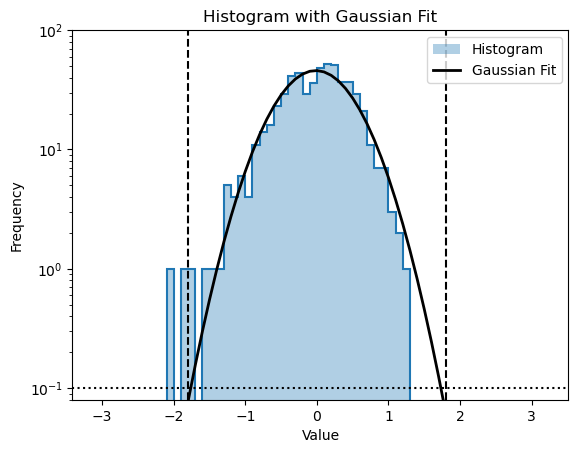

,tas,hour,month,time
96556,-1.715947,0,12,2013-12-07 00:15:00
96577,-2.045080,0,12,2013-12-08 00:15:00
96601,-1.886447,0,12,2013-12-09 00:15:00


1


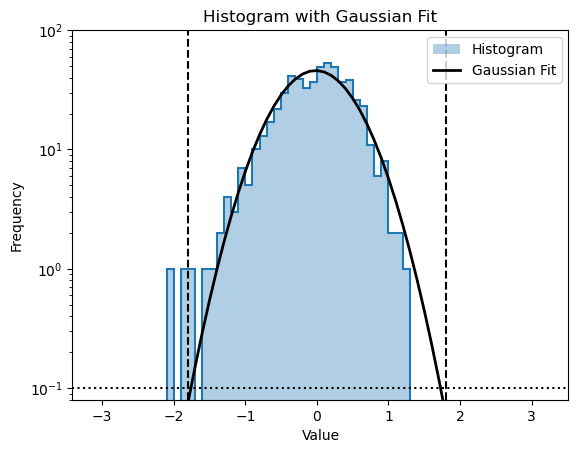

,tas,hour,month,time
96557,-1.734751,1,12,2013-12-07 01:15:00
96578,-2.049672,1,12,2013-12-08 01:15:00
96602,-1.877256,1,12,2013-12-09 01:15:00


2


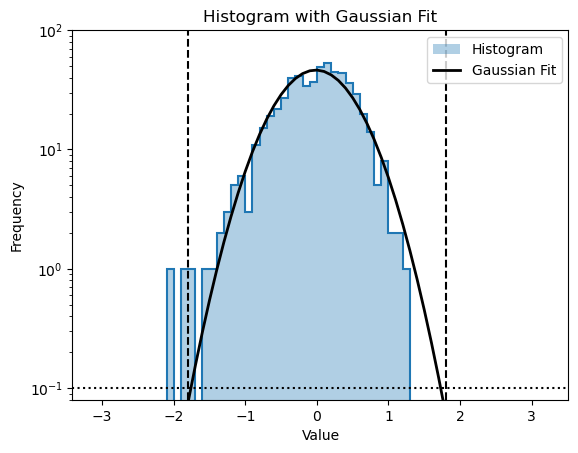

,tas,hour,month,time
96558,-1.751643,2,12,2013-12-07 02:15:00
96579,-2.048629,2,12,2013-12-08 02:15:00
96603,-1.866855,2,12,2013-12-09 02:15:00


3


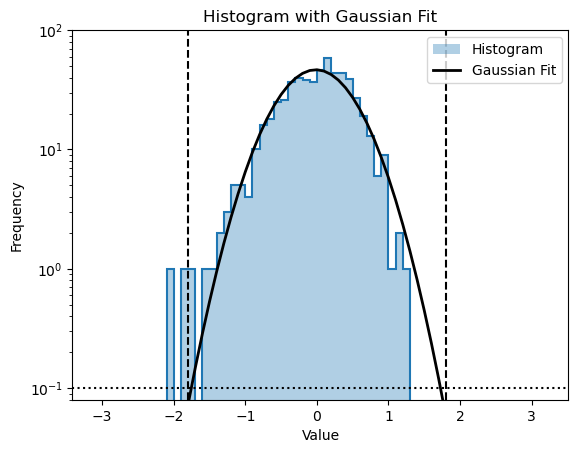

,tas,hour,month,time
96559,-1.769787,3,12,2013-12-07 03:15:00
96580,-2.046410,3,12,2013-12-08 03:15:00
96604,-1.857609,3,12,2013-12-09 03:15:00


4


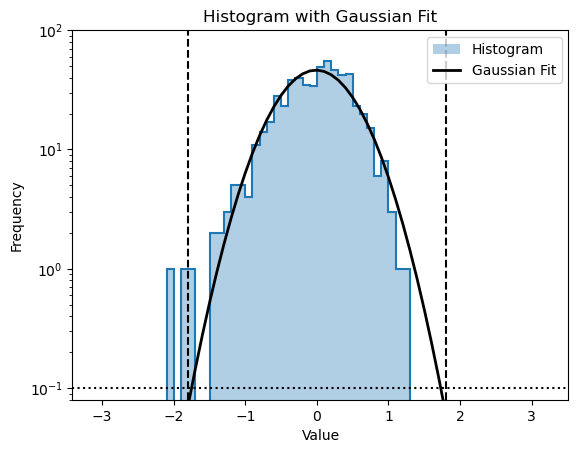

,tas,hour,month,time
96560,-1.788649,4,12,2013-12-07 04:15:00
96581,-2.043117,4,12,2013-12-08 04:15:00
96605,-1.849572,4,12,2013-12-09 04:15:00


5


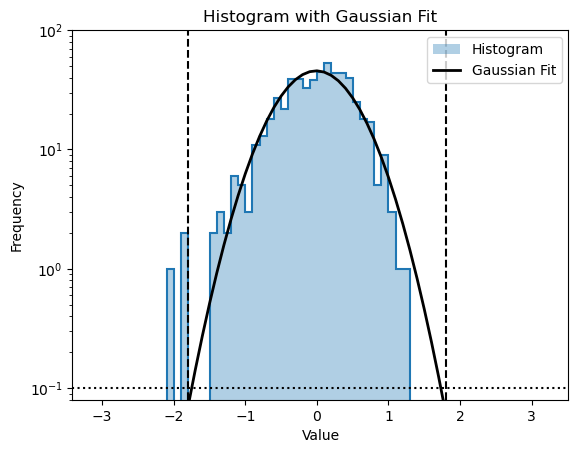

,tas,hour,month,time
96561,-1.805165,5,12,2013-12-07 05:15:00
96582,-2.037215,5,12,2013-12-08 05:15:00
96606,-1.842227,5,12,2013-12-09 05:15:00


6


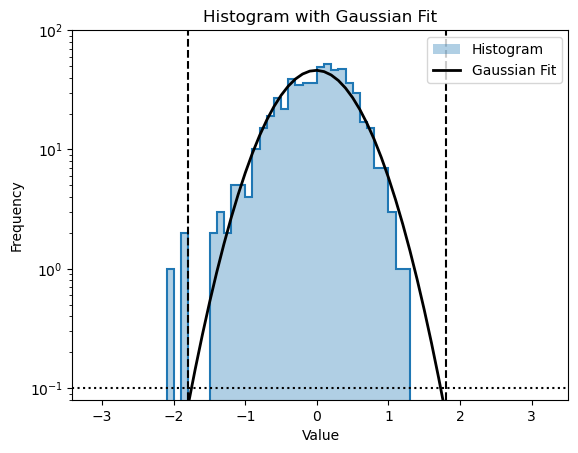

,tas,hour,month,time
96562,-1.821717,6,12,2013-12-07 06:15:00
96583,-2.029304,6,12,2013-12-08 06:15:00
96607,-1.837286,6,12,2013-12-09 06:15:00


7


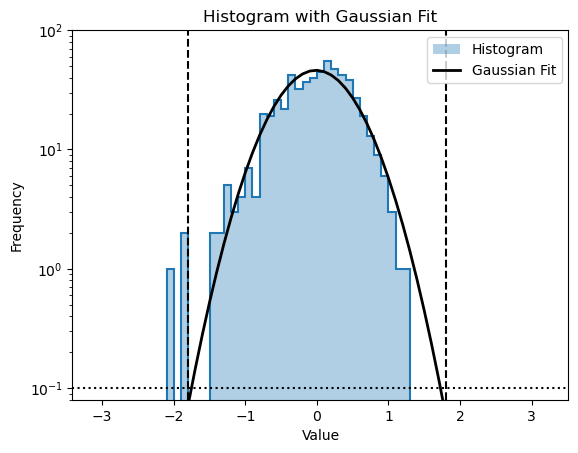

,tas,hour,month,time
96563,-1.841255,7,12,2013-12-07 07:15:00
96584,-2.018724,7,12,2013-12-08 07:15:00
96608,-1.836432,7,12,2013-12-09 07:15:00


8


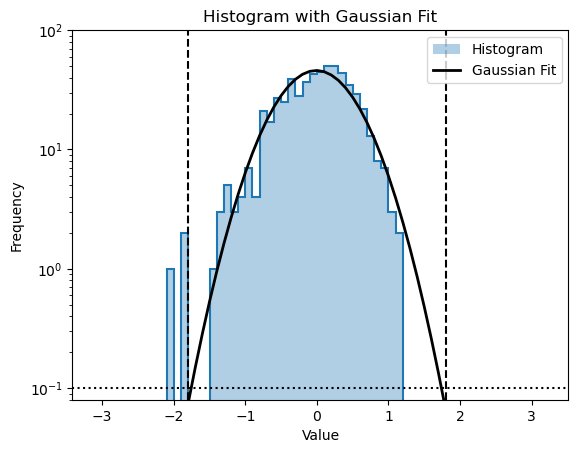

,tas,hour,month,time
96564,-1.862673,8,12,2013-12-07 08:15:00
96585,-2.006689,8,12,2013-12-08 08:15:00
96609,-1.840573,8,12,2013-12-09 08:15:00


9


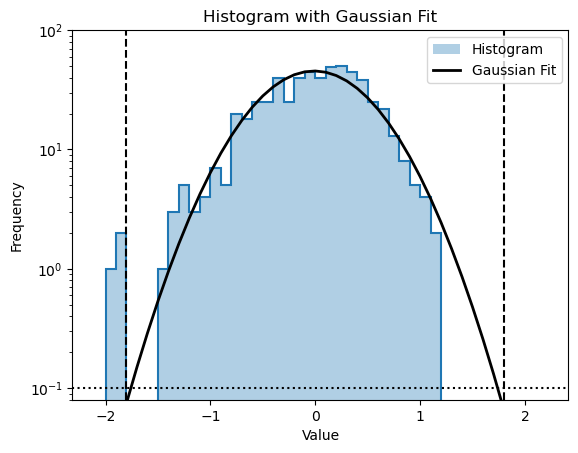

,tas,hour,month,time
96565,-1.885323,9,12,2013-12-07 09:15:00
96586,-1.997668,9,12,2013-12-08 09:15:00
96610,-1.845734,9,12,2013-12-09 09:15:00


10


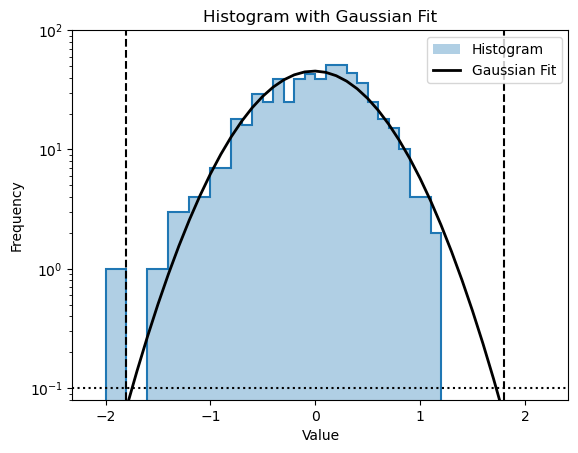

,tas,hour,month,time
96587,-1.991514,10,12,2013-12-08 10:15:00
96611,-1.848131,10,12,2013-12-09 10:15:00


11


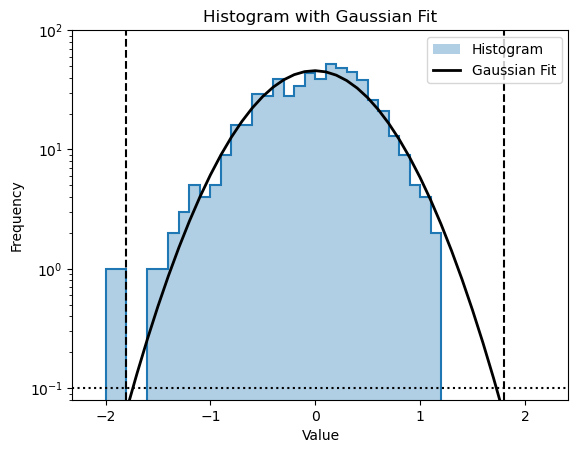

,tas,hour,month,time
96588,-1.986200,11,12,2013-12-08 11:15:00
96612,-1.849138,11,12,2013-12-09 11:15:00


12


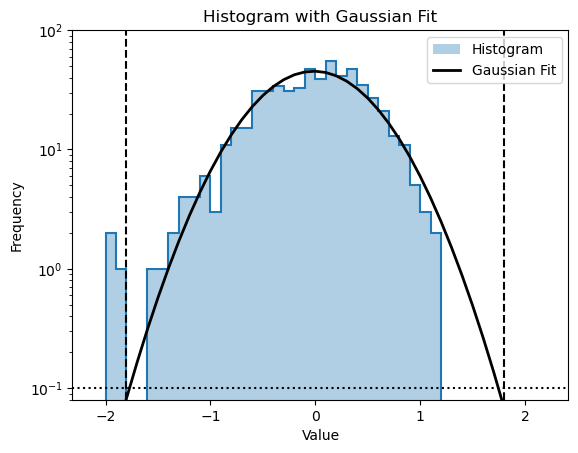

,tas,hour,month,time
96566,-1.907991,12,12,2013-12-07 12:15:00
96589,-1.981484,12,12,2013-12-08 12:15:00
96613,-1.847280,12,12,2013-12-09 12:15:00


13


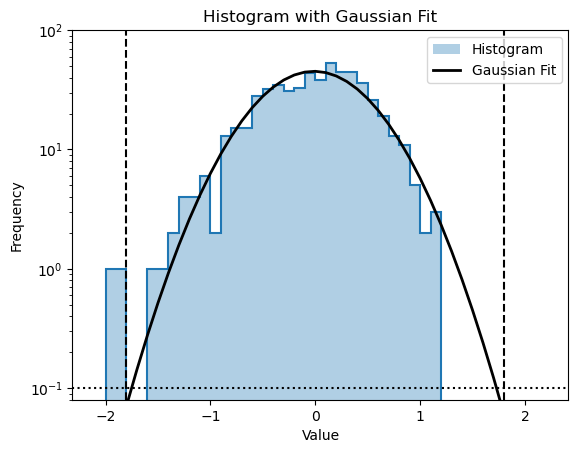

,tas,hour,month,time
96590,-1.977610,13,12,2013-12-08 13:15:00
96614,-1.832988,13,12,2013-12-09 13:15:00


14


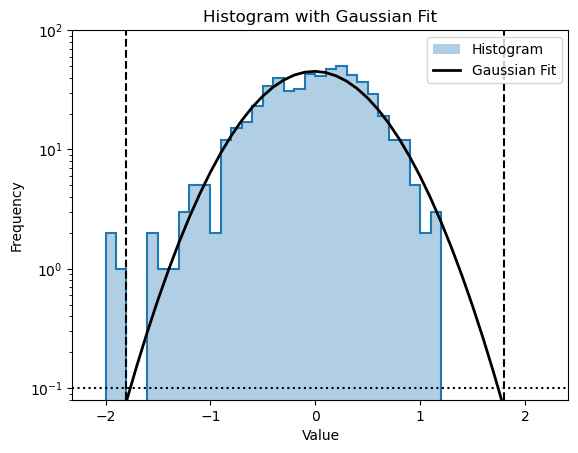

,tas,hour,month,time
96567,-1.926925,14,12,2013-12-07 14:15:00
96591,-1.971385,14,12,2013-12-08 14:15:00
96615,-1.807909,14,12,2013-12-09 14:15:00


15


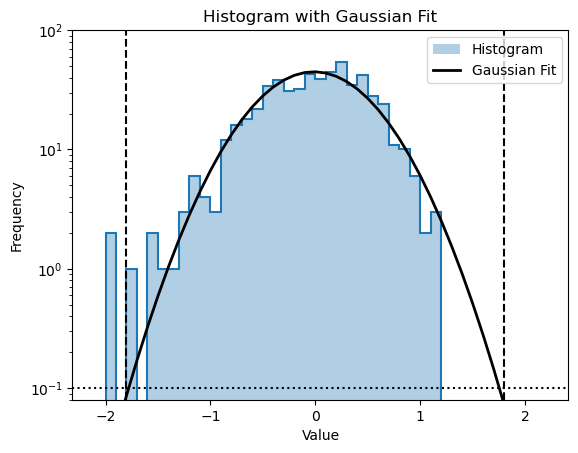

,tas,hour,month,time
96568,-1.939985,15,12,2013-12-07 15:15:00
96592,-1.963461,15,12,2013-12-08 15:15:00
96616,-1.783405,15,12,2013-12-09 15:15:00


16


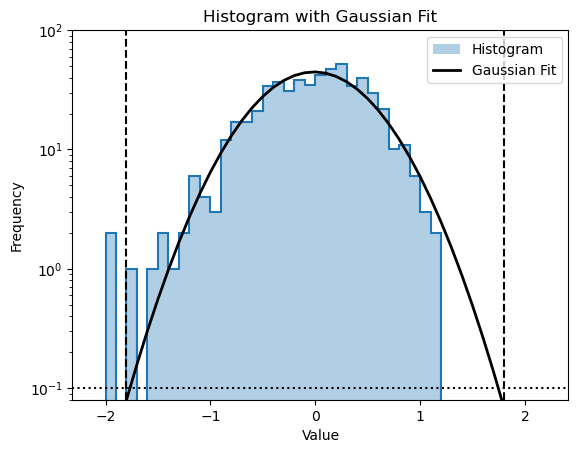

,tas,hour,month,time
96569,-1.952050,16,12,2013-12-07 16:15:00
96593,-1.956294,16,12,2013-12-08 16:15:00
96617,-1.757369,16,12,2013-12-09 16:15:00


17


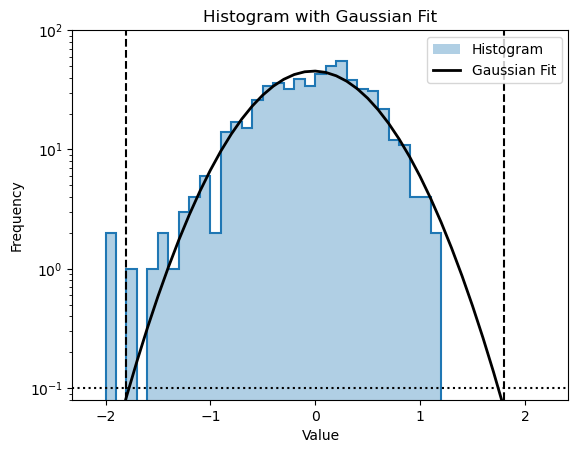

,tas,hour,month,time
96570,-1.968923,17,12,2013-12-07 17:15:00
96594,-1.947803,17,12,2013-12-08 17:15:00
96618,-1.733827,17,12,2013-12-09 17:15:00


18


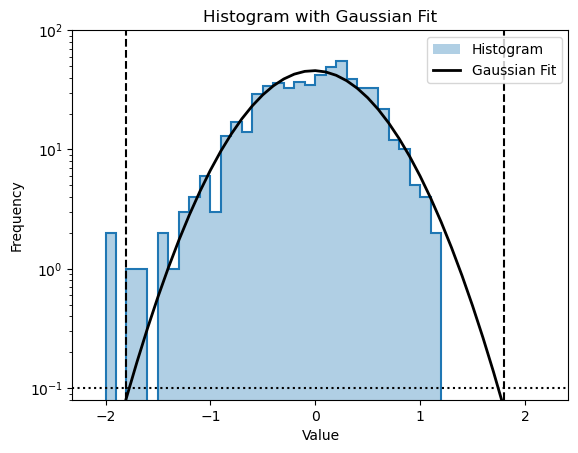

,tas,hour,month,time
96550,-1.602577,18,12,2013-12-06 18:15:00
96571,-1.985903,18,12,2013-12-07 18:15:00
96595,-1.941161,18,12,2013-12-08 18:15:00
96619,-1.716985,18,12,2013-12-09 18:15:00


19


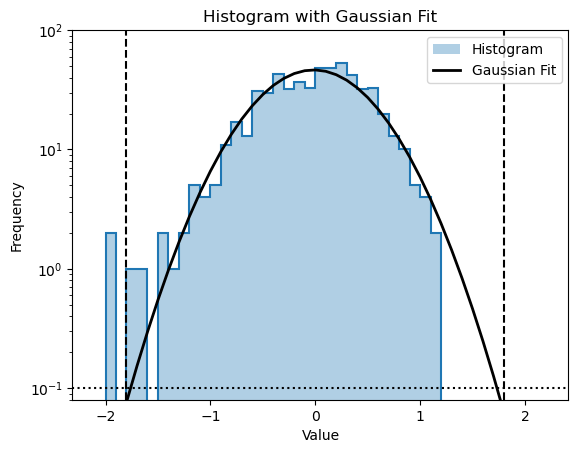

,tas,hour,month,time
96551,-1.619848,19,12,2013-12-06 19:15:00
96572,-1.996265,19,12,2013-12-07 19:15:00
96596,-1.933626,19,12,2013-12-08 19:15:00
96620,-1.700413,19,12,2013-12-09 19:15:00


20


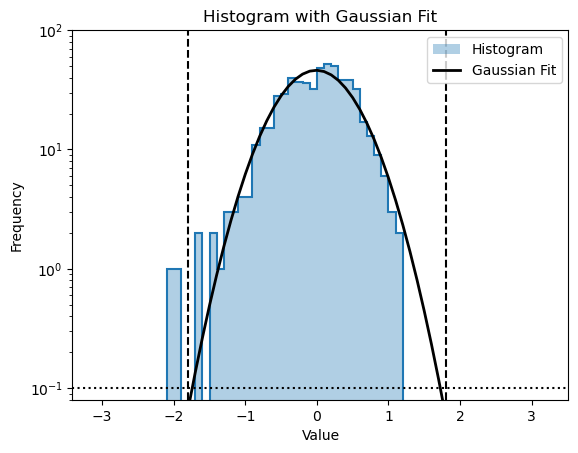

,tas,hour,month,time
96552,-1.637174,20,12,2013-12-06 20:15:00
96573,-2.005577,20,12,2013-12-07 20:15:00
96597,-1.921172,20,12,2013-12-08 20:15:00
96621,-1.680199,20,12,2013-12-09 20:15:00


21


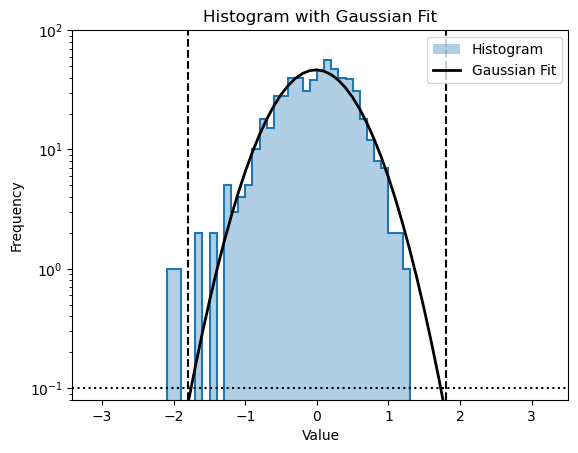

,tas,hour,month,time
96553,-1.656775,21,12,2013-12-06 21:15:00
96574,-2.016153,21,12,2013-12-07 21:15:00
96598,-1.910479,21,12,2013-12-08 21:15:00
96622,-1.657486,21,12,2013-12-09 21:15:00


22


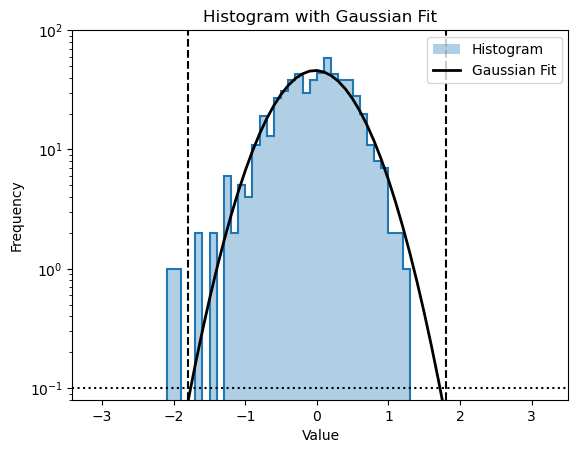

,tas,hour,month,time
96554,-1.676136,22,12,2013-12-06 22:15:00
96575,-2.025500,22,12,2013-12-07 22:15:00
96599,-1.901967,22,12,2013-12-08 22:15:00
96623,-1.634253,22,12,2013-12-09 22:15:00


23


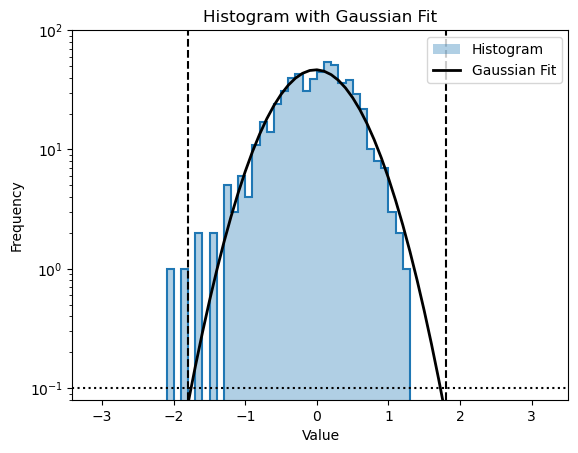

,tas,hour,month,time
96555,-1.695620,23,12,2013-12-06 23:15:00
96576,-2.035114,23,12,2013-12-07 23:15:00
96600,-1.894138,23,12,2013-12-08 23:15:00
96624,-1.609595,23,12,2013-12-09 23:15:00


In [87]:
for hour in range(0,24,1):
    series = data[(data.month==12)&(data.hour==hour)]
    print(hour)
    freq, bins, p, left, right = fit_normal(series['tas'], bin_size=0.10, plot=True)
    display(series[series['tas']<-1.6])

In [ ]:
test_df = qaqc_climatological_outlier(stn_to_qaqc, verbose=verbose, local=True, plot=True)

In [433]:
fig,ax = plt.subplots(figsize=(10,3))

df.plot(x="time", y="tas", ax=ax, marker=".", color="C0")
ax.set_xlim(np.datetime64("2003-11-28"),np.datetime64("2003-12-01"))
ax.axvline(np.datetime64("2003-11-29 02:45:00"), ls=":", c="C0")
ax.set_ylim(255,285)

axt = ax.twiny()
df.plot(x="time", y="tas", ax=axt, marker=".", color="C1")
axt.set_xlim(np.datetime64("2002-11-28"),np.datetime64("2002-12-01"))
axt.set_ylim(255,285)

# fig,ax = plt.subplots(figsize=(10,3))
axtt = axt.twiny()
df.plot(x="time", y="tas", ax=axtt, marker=".", color="C2")
axtt.set_xlim(np.datetime64("2016-11-28"),np.datetime64("2016-12-01"))
axtt.set_ylim(255,285)

axttt = axtt.twiny()
df.plot(x="time", y="tas", ax=axttt, marker=".", color="C3")
axttt.set_xlim(np.datetime64("2005-11-28"),np.datetime64("2005-12-01"))
axttt.set_ylim(255,285)

(255.0, 285.0)

(255.0, 285.0)

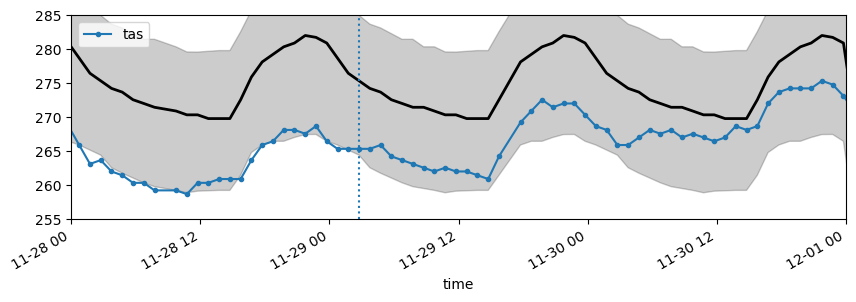

In [280]:
fig,ax = plt.subplots(figsize=(10,3))

ax.plot(df.time, df.groupby(["month","hour"]).tas.transform(lambda row: np.nanmedian(row)), lw=2, c="k")
y1 = stn_to_qaqc.groupby(["month","hour"]).tas.transform(lambda row: np.percentile(row,  1)).interpolate(method="linear")
y2 = stn_to_qaqc.groupby(["month","hour"]).tas.transform(lambda row: np.percentile(row, 99))
ax.fill_between(df.time, y1, y2, color="k", alpha=0.2)

df.plot(x="time", y="tas", ax=ax, marker=".", color="C0")
ax.set_xlim(np.datetime64("2003-11-28"),np.datetime64("2003-12-01"))
ax.axvline(np.datetime64("2003-11-29 02:45:00"), ls=":", c="C0")
ax.set_ylim(255,285)


0
0.08 1


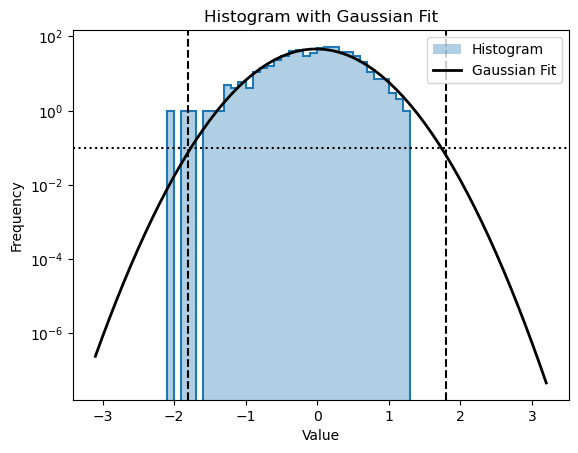

,tas,hour,month,time
96556,-1.715947,0,12,2013-12-07 00:15:00
96577,-2.045080,0,12,2013-12-08 00:15:00
96601,-1.886447,0,12,2013-12-09 00:15:00


1
0.08 1


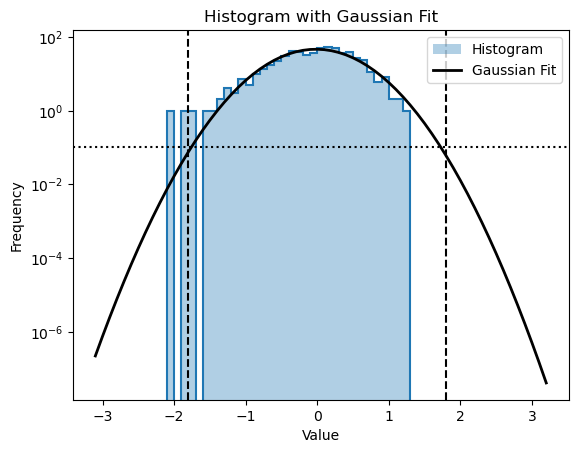

,tas,hour,month,time
96557,-1.734751,1,12,2013-12-07 01:15:00
96578,-2.049672,1,12,2013-12-08 01:15:00
96602,-1.877256,1,12,2013-12-09 01:15:00


2
0.08 1


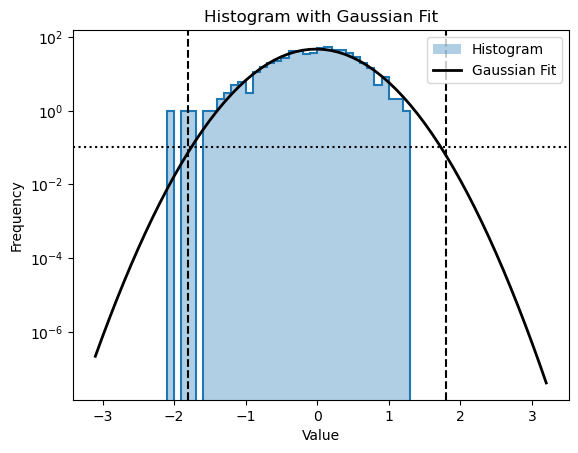

,tas,hour,month,time
96558,-1.751643,2,12,2013-12-07 02:15:00
96579,-2.048629,2,12,2013-12-08 02:15:00
96603,-1.866855,2,12,2013-12-09 02:15:00


3
0.08 1


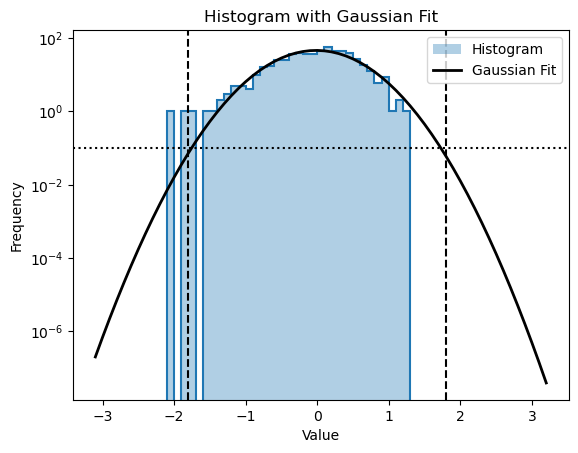

,tas,hour,month,time
96559,-1.769787,3,12,2013-12-07 03:15:00
96580,-2.046410,3,12,2013-12-08 03:15:00
96604,-1.857609,3,12,2013-12-09 03:15:00


4
0.08 1


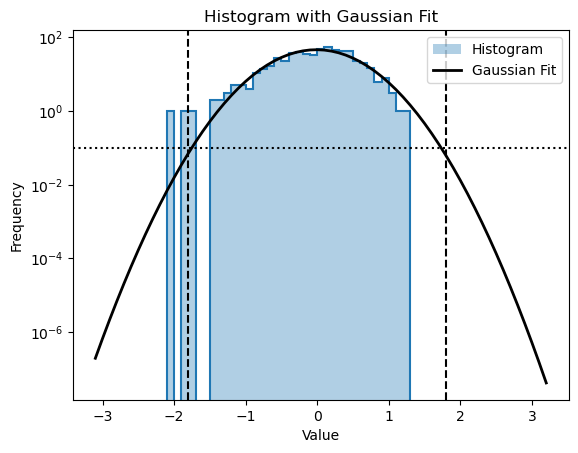

,tas,hour,month,time
96560,-1.788649,4,12,2013-12-07 04:15:00
96581,-2.043117,4,12,2013-12-08 04:15:00
96605,-1.849572,4,12,2013-12-09 04:15:00


5
0.08 1


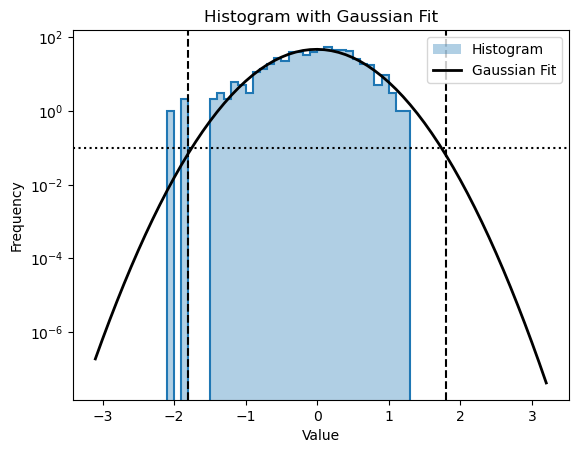

,tas,hour,month,time
96561,-1.805165,5,12,2013-12-07 05:15:00
96582,-2.037215,5,12,2013-12-08 05:15:00
96606,-1.842227,5,12,2013-12-09 05:15:00


6
0.08 1


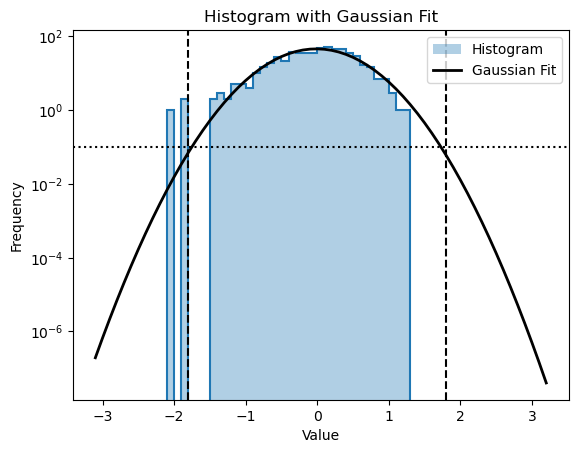

,tas,hour,month,time
96562,-1.821717,6,12,2013-12-07 06:15:00
96583,-2.029304,6,12,2013-12-08 06:15:00
96607,-1.837286,6,12,2013-12-09 06:15:00


7
0.08 1


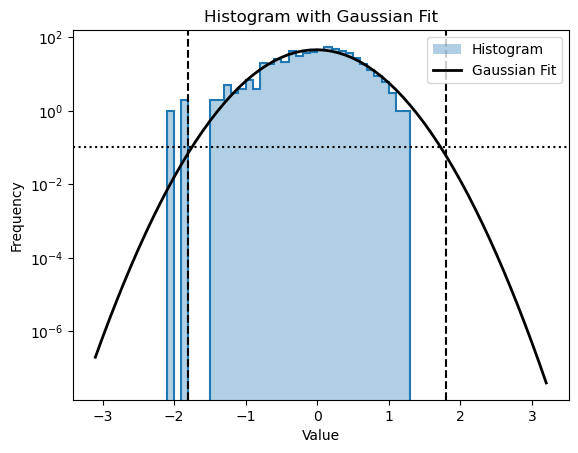

,tas,hour,month,time
96563,-1.841255,7,12,2013-12-07 07:15:00
96584,-2.018724,7,12,2013-12-08 07:15:00
96608,-1.836432,7,12,2013-12-09 07:15:00


8
0.08 1


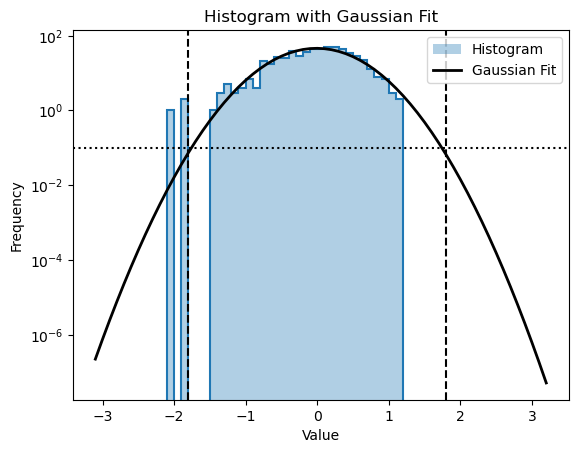

,tas,hour,month,time
96564,-1.862673,8,12,2013-12-07 08:15:00
96585,-2.006689,8,12,2013-12-08 08:15:00
96609,-1.840573,8,12,2013-12-09 08:15:00


9
0.08 1


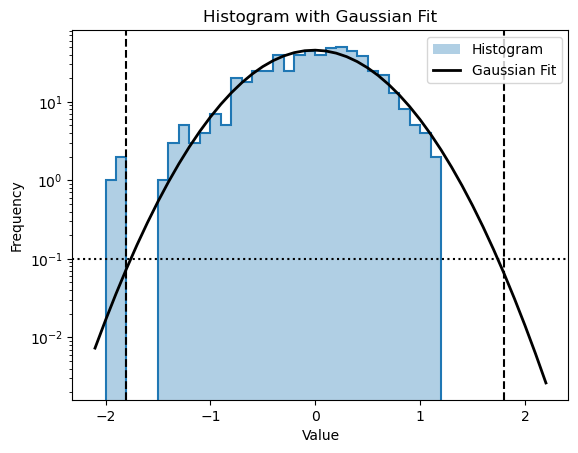

,tas,hour,month,time
96565,-1.885323,9,12,2013-12-07 09:15:00
96586,-1.997668,9,12,2013-12-08 09:15:00
96610,-1.845734,9,12,2013-12-09 09:15:00


10
0.08 1


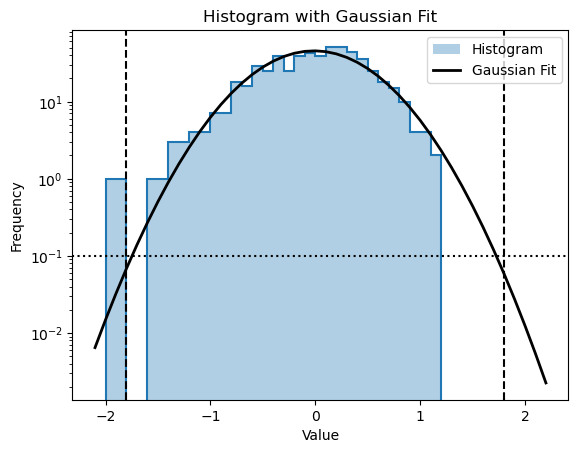

,tas,hour,month,time
96587,-1.991514,10,12,2013-12-08 10:15:00
96611,-1.848131,10,12,2013-12-09 10:15:00


11
0.08 1


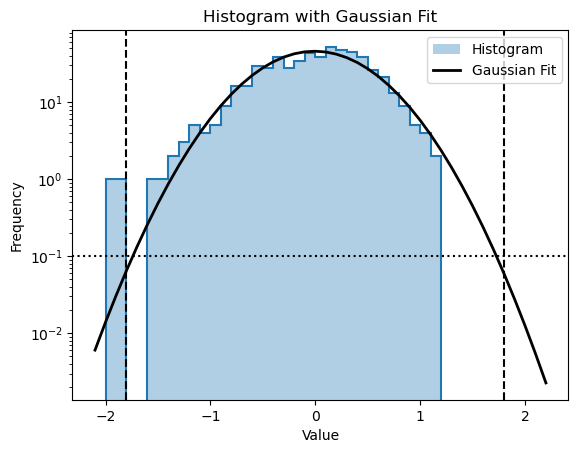

,tas,hour,month,time
96588,-1.986200,11,12,2013-12-08 11:15:00
96612,-1.849138,11,12,2013-12-09 11:15:00


12
0.08 1


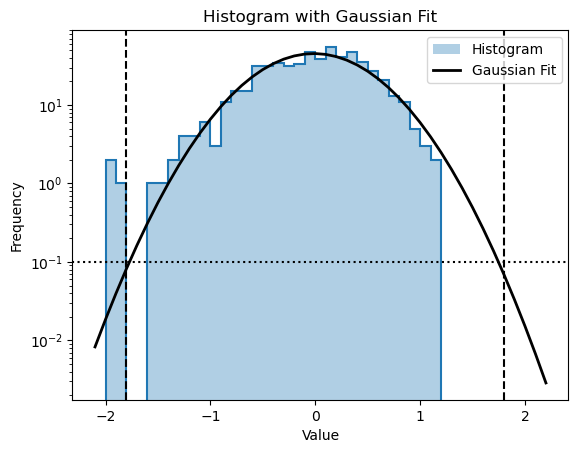

,tas,hour,month,time
96566,-1.907991,12,12,2013-12-07 12:15:00
96589,-1.981484,12,12,2013-12-08 12:15:00
96613,-1.847280,12,12,2013-12-09 12:15:00


13
0.08 1


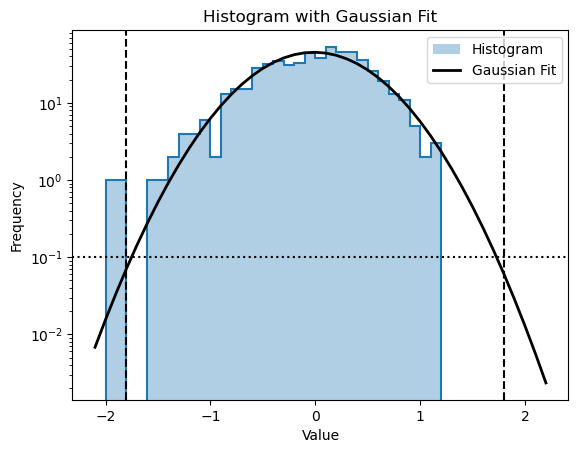

,tas,hour,month,time
96590,-1.977610,13,12,2013-12-08 13:15:00
96614,-1.832988,13,12,2013-12-09 13:15:00


14
0.08 1


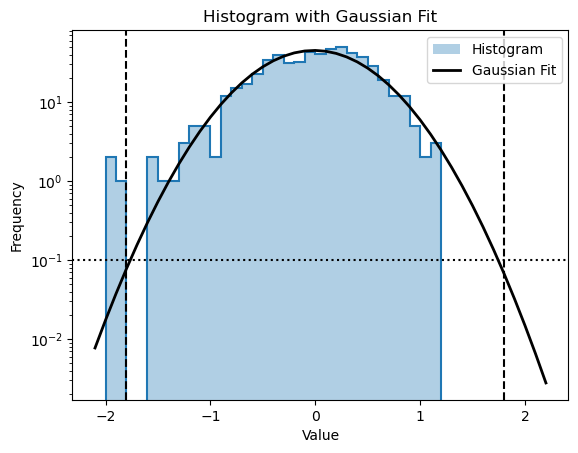

,tas,hour,month,time
96567,-1.926925,14,12,2013-12-07 14:15:00
96591,-1.971385,14,12,2013-12-08 14:15:00
96615,-1.807909,14,12,2013-12-09 14:15:00


15
0.08 1


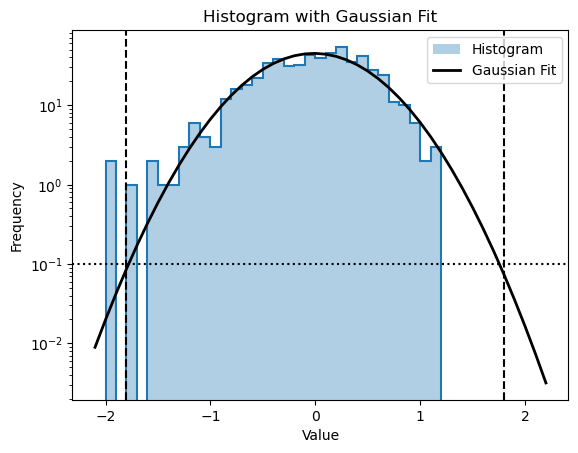

,tas,hour,month,time
96568,-1.939985,15,12,2013-12-07 15:15:00
96592,-1.963461,15,12,2013-12-08 15:15:00
96616,-1.783405,15,12,2013-12-09 15:15:00


16
0.08 1


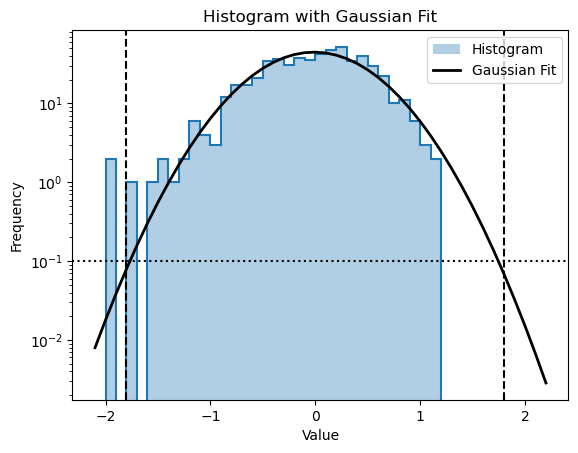

,tas,hour,month,time
96569,-1.952050,16,12,2013-12-07 16:15:00
96593,-1.956294,16,12,2013-12-08 16:15:00
96617,-1.757369,16,12,2013-12-09 16:15:00


17
0.08 1


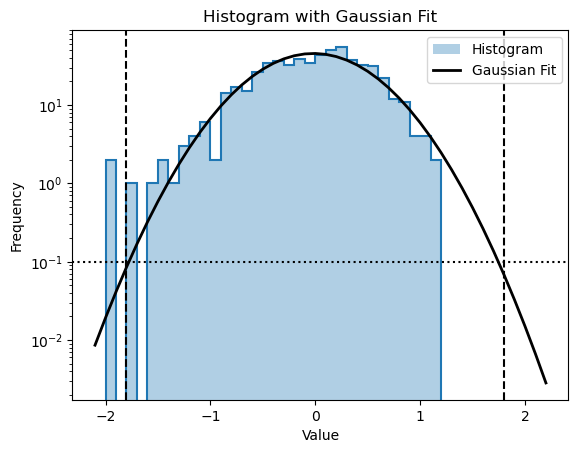

,tas,hour,month,time
96570,-1.968923,17,12,2013-12-07 17:15:00
96594,-1.947803,17,12,2013-12-08 17:15:00
96618,-1.733827,17,12,2013-12-09 17:15:00


18
0.08 1


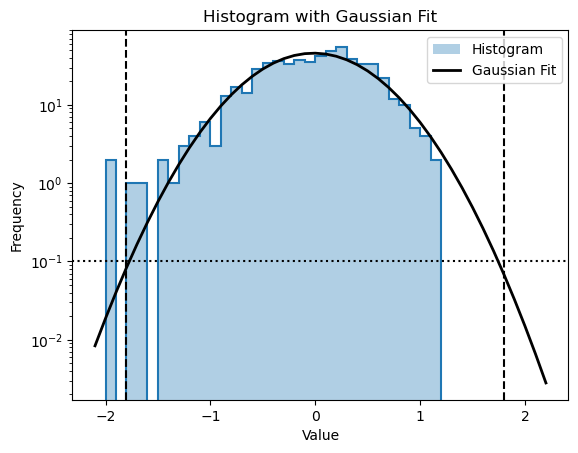

,tas,hour,month,time
96550,-1.602577,18,12,2013-12-06 18:15:00
96571,-1.985903,18,12,2013-12-07 18:15:00
96595,-1.941161,18,12,2013-12-08 18:15:00
96619,-1.716985,18,12,2013-12-09 18:15:00


19
0.08 1


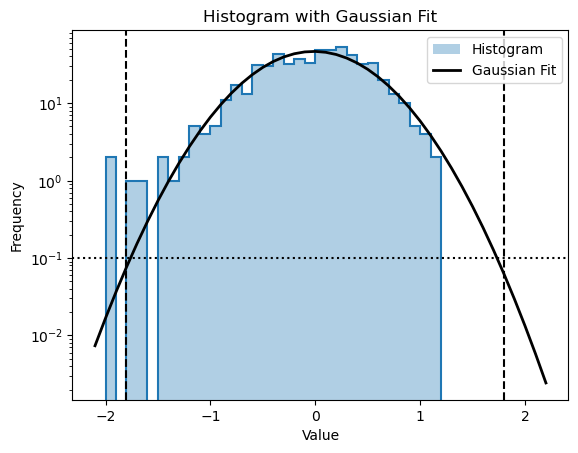

,tas,hour,month,time
96551,-1.619848,19,12,2013-12-06 19:15:00
96572,-1.996265,19,12,2013-12-07 19:15:00
96596,-1.933626,19,12,2013-12-08 19:15:00
96620,-1.700413,19,12,2013-12-09 19:15:00


20
0.08 1


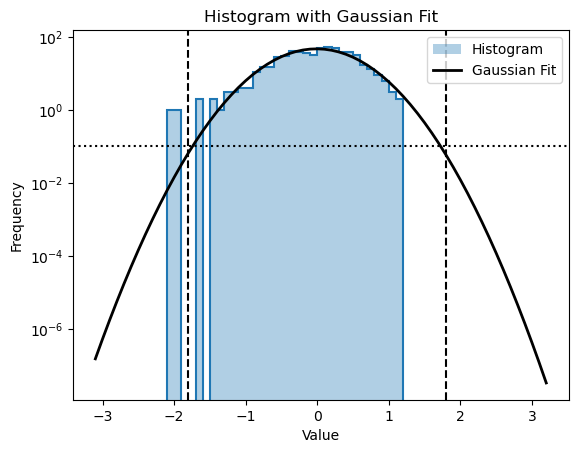

,tas,hour,month,time
96552,-1.637174,20,12,2013-12-06 20:15:00
96573,-2.005577,20,12,2013-12-07 20:15:00
96597,-1.921172,20,12,2013-12-08 20:15:00
96621,-1.680199,20,12,2013-12-09 20:15:00


21
0.08 1


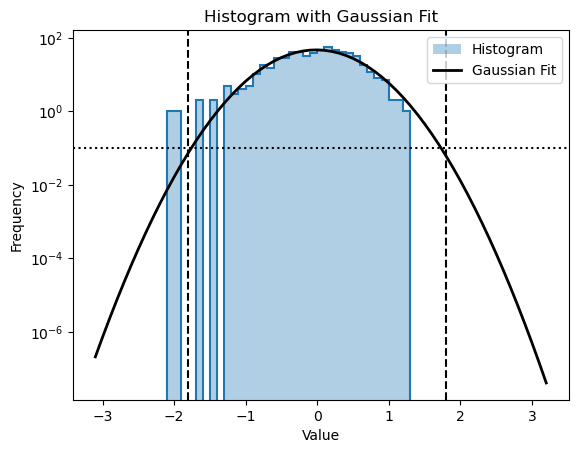

,tas,hour,month,time
96553,-1.656775,21,12,2013-12-06 21:15:00
96574,-2.016153,21,12,2013-12-07 21:15:00
96598,-1.910479,21,12,2013-12-08 21:15:00
96622,-1.657486,21,12,2013-12-09 21:15:00


22
0.08 1


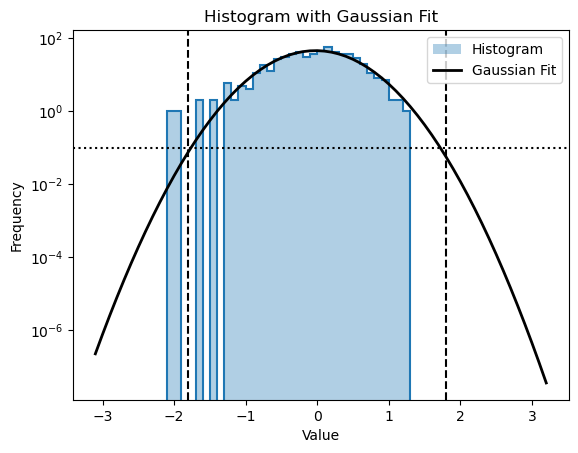

,tas,hour,month,time
96554,-1.676136,22,12,2013-12-06 22:15:00
96575,-2.025500,22,12,2013-12-07 22:15:00
96599,-1.901967,22,12,2013-12-08 22:15:00
96623,-1.634253,22,12,2013-12-09 22:15:00


23
0.08 1


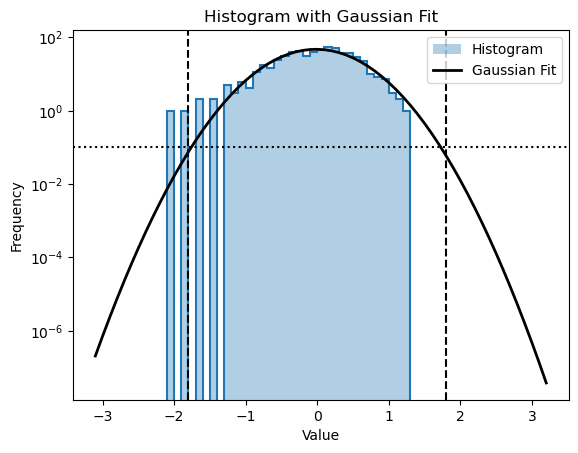

,tas,hour,month,time
96555,-1.695620,23,12,2013-12-06 23:15:00
96576,-2.035114,23,12,2013-12-07 23:15:00
96600,-1.894138,23,12,2013-12-08 23:15:00
96624,-1.609595,23,12,2013-12-09 23:15:00


In [80]:
for hour in range(0,24,1):
    series = data[(data.month==12)&(data.hour==hour)]
    print(hour)
    freq, bins, p, left, right = fit_normal(series['tas'], bin_size=0.10, plot=True)
    display(series[series['tas']<-1.6])

In [ ]:
96552	-1.637174	20	12	2013-12-06 20:15:00
96573	-2.005577	20	12	2013-12-07 20:15:00
96597	-1.921172	20	12	2013-12-08 20:15:00
96621	-1.680199	20	12	2013-12-09 20:15:00

(16040.0, 16051.0)

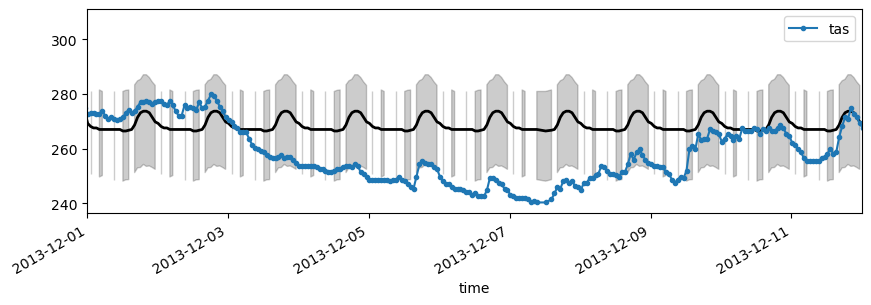

In [88]:
fig,ax = plt.subplots(figsize=(10,3))

ax.plot(df.time, df.groupby(["month","hour"]).tas.transform(lambda row: np.nanmedian(row)), lw=2, c="k")
y1 = stn_to_qaqc.groupby(["month","hour"]).tas.transform(lambda row: np.percentile(row,  1)).interpolate(method="linear")
y2 = stn_to_qaqc.groupby(["month","hour"]).tas.transform(lambda row: np.percentile(row, 99))
ax.fill_between(df.time, y1, y2, color="k", alpha=0.2)

df.plot(x="time", y="tas", ax=ax, marker=".", color="C0")
ax.set_xlim(np.datetime64("2013-12-01"),np.datetime64("2013-12-12"))
# ax.axvline(np.datetime64("2013-11-29 02:45:00"), ls=":", c="C0")
# ax.set_ylim(255,285)


In [73]:
ds.lon.mean(), ds.lat.mean()

(<xarray.DataArray 'lon' ()>
 array(-109.360556),
 <xarray.DataArray 'lat' ()>
 array(45.156944))

In [121]:
df

,time,tas,pr,hurs,sfcWind,sfcWind_dir,tas_qc,hurs_qc,sfcWind_qc,sfcWind_dir_qc,...,tdps_derived_eraqc,elevation_eraqc,anemometer_height_m,thermometer_height_m,station,hour,day,month,year,date
0,2007-09-07 20:20:00,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,...,NaN,NaN,NaN,NaN,RAWS_TR782,20,7,9,2007,2007-09-07
1,2008-01-23 20:29:00,279.820,0.0,NaN,NaN,NaN,nan,nan,nan,nan,...,NaN,NaN,NaN,NaN,RAWS_TR782,20,23,1,2008,2008-01-23
2,2008-01-23 21:29:00,279.260,0.0,50.0,2.680,120.0,nan,nan,nan,nan,...,NaN,NaN,NaN,NaN,RAWS_TR782,21,23,1,2008,2008-01-23
3,2008-01-23 22:29:00,278.710,0.0,51.0,0.900,114.0,nan,nan,nan,nan,...,NaN,NaN,NaN,NaN,RAWS_TR782,22,23,1,2008,2008-01-23
4,2008-01-23 23:29:00,278.150,0.0,59.0,1.790,154.0,nan,nan,nan,nan,...,NaN,NaN,NaN,NaN,RAWS_TR782,23,23,1,2008,2008-01-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92780,2022-05-18 15:14:00,289.817,0.0,65.0,1.343,72.0,nan,nan,nan,3,...,NaN,NaN,NaN,NaN,RAWS_TR782,15,18,5,2022,2022-05-18
92781,2022-05-18 16:14:00,294.261,0.0,53.0,0.895,135.0,nan,nan,nan,3,...,NaN,NaN,NaN,NaN,RAWS_TR782,16,18,5,2022,2022-05-18
92782,2022-05-18 17:14:00,297.039,0.0,46.0,0.895,162.0,nan,nan,nan,3,...,NaN,NaN,NaN,NaN,RAWS_TR782,17,18,5,2022,2022-05-18
92783,2022-05-18 18:14:00,298.150,0.0,45.0,0.895,231.0,nan,nan,nan,3,...,NaN,NaN,NaN,NaN,RAWS_TR782,18,18,5,2022,2022-05-18


In [120]:
df.dropna(subset="tas")

,time,tas,pr,hurs,sfcWind,sfcWind_dir,tas_qc,hurs_qc,sfcWind_qc,sfcWind_dir_qc,...,tdps_derived_eraqc,elevation_eraqc,anemometer_height_m,thermometer_height_m,station,hour,day,month,year,date
1,2008-01-23 20:29:00,279.820,0.0,NaN,NaN,NaN,nan,nan,nan,nan,...,NaN,NaN,NaN,NaN,RAWS_TR782,20,23,1,2008,2008-01-23
2,2008-01-23 21:29:00,279.260,0.0,50.0,2.680,120.0,nan,nan,nan,nan,...,NaN,NaN,NaN,NaN,RAWS_TR782,21,23,1,2008,2008-01-23
3,2008-01-23 22:29:00,278.710,0.0,51.0,0.900,114.0,nan,nan,nan,nan,...,NaN,NaN,NaN,NaN,RAWS_TR782,22,23,1,2008,2008-01-23
4,2008-01-23 23:29:00,278.150,0.0,59.0,1.790,154.0,nan,nan,nan,nan,...,NaN,NaN,NaN,NaN,RAWS_TR782,23,23,1,2008,2008-01-23
5,2008-01-24 00:29:00,275.930,0.0,60.0,0.450,158.0,nan,nan,nan,nan,...,NaN,NaN,NaN,NaN,RAWS_TR782,0,24,1,2008,2008-01-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92780,2022-05-18 15:14:00,289.817,0.0,65.0,1.343,72.0,nan,nan,nan,3,...,NaN,NaN,NaN,NaN,RAWS_TR782,15,18,5,2022,2022-05-18
92781,2022-05-18 16:14:00,294.261,0.0,53.0,0.895,135.0,nan,nan,nan,3,...,NaN,NaN,NaN,NaN,RAWS_TR782,16,18,5,2022,2022-05-18
92782,2022-05-18 17:14:00,297.039,0.0,46.0,0.895,162.0,nan,nan,nan,3,...,NaN,NaN,NaN,NaN,RAWS_TR782,17,18,5,2022,2022-05-18
92783,2022-05-18 18:14:00,298.150,0.0,45.0,0.895,231.0,nan,nan,nan,3,...,NaN,NaN,NaN,NaN,RAWS_TR782,18,18,5,2022,2022-05-18
